# Phase 3 Data Science Training Notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [3]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
b1 = unpickle("cifar-10-batches-py/data_batch_1")
b2 = unpickle("cifar-10-batches-py/data_batch_2")
b3 = unpickle("cifar-10-batches-py/data_batch_3")
b4 = unpickle("cifar-10-batches-py/data_batch_4")
b5 = unpickle("cifar-10-batches-py/data_batch_5")
test = unpickle("cifar-10-batches-py/test_batch")

print(test.keys())
testData = test[b'data']
reshapedTest = testData.reshape(len(testData),3,32,32).transpose(0,2,3,1)
reshapedTest.shape



dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


(10000, 32, 32, 3)

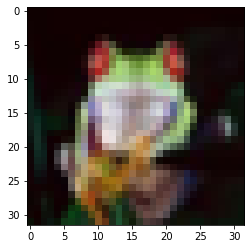

In [22]:
i = 102
plt.imshow(reshapedTest[i])

In [5]:
lableList = []
lableList += b1[b'labels']
lableList += b2[b'labels']
lableList += b3[b'labels']
lableList += b4[b'labels']
lableList += b5[b'labels']

dataList = np.concatenate((b1[b'data'],b2[b'data'],b3[b'data'],b4[b'data'],b5[b'data']),axis = 0)
dataList.shape

(50000, 3072)

In [6]:
dataList = dataList.reshape(len(dataList),3,32,32).transpose(0,2,3,1)
dataList.shape

(50000, 32, 32, 3)

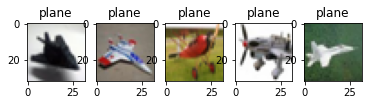

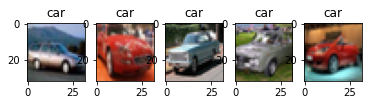

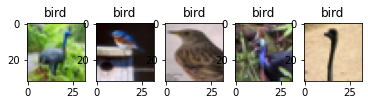

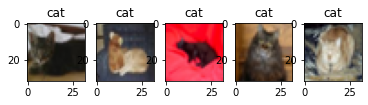

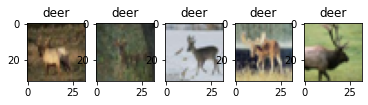

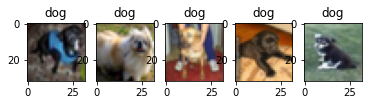

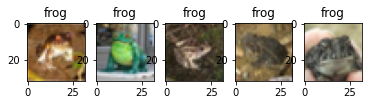

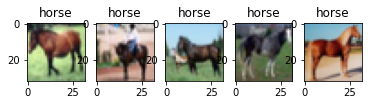

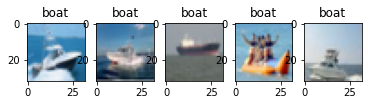

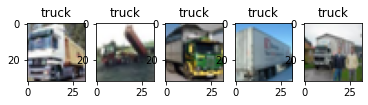

In [7]:
plane_list = []
car_list = []
bird_list = []
cat_list = []
deer_list = []
dog_list = []
frog_list = []
horse_list = []
ship_list = []
truck_list = []
list_of_lists = [plane_list,car_list,bird_list,cat_list,deer_list,dog_list,frog_list,horse_list,ship_list,truck_list]
names =  ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "boat", "truck"]

for list in range(len(list_of_lists)):
    for i in range(len(lableList)):
        if lableList[i] == list:
            list_of_lists[list].append(i)

j = 0
for list in list_of_lists:
    for i in range(5):
        img = dataList[list[i]]
        plt.subplot(1,5,i+1)
        plt.title(names[j])
        plt.imshow(img)
    j += 1    
    plt.show()



I will pick boats for this model.

In [8]:
boat_index = list_of_lists[9]


# Data Processing

In [9]:
train_x = dataList
train_y = np.array(lableList)

test_x = reshapedTest
test_y = np.array(test[b'labels'])

train_x, test_x = train_x / 255.0, test_x / 255.0

# Data Modelling

In [10]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks,datasets, models
from datetime import datetime

from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime
import kerastuner as kt

In [18]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(32,32,3))) # Input layer.

    model.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.

    model.add(layers.Dense(3000, activation="relu")) # Example Hidden Layer 1. Has 40 Nodes.
    model.add(layers.Dense(1000, activation="sigmoid")) # Example Hidden Layer 2. Has 25 Nodes.
    model.add(layers.Dense(200, activation="tanh")) # Example Hidden Layer 3. Has 15 Nodes.

    model.add(layers.Dense(1, activation="sigmoid", name="Output_Probability")) # Output layer.

    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.01),
        loss=losses.MeanAbsoluteError(),
        metrics=['accuracy']
    )

    return model

In [ ]:
import os


def model_builder(hp):
    mlmodel = keras.Sequential()

    mlmodel.add(keras.layers.Flatten(input_shape=(32,32,3)))
    hp_units = hp.Int('units', min_value = 32, max_value=512, step=32)
    mlmodel.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
    mlmodel.add(keras.layers.Dropout(0.2))
    mlmodel.add(keras.layers.Dense(100, activation='relu'))
    mlmodel.add(keras.layers.Dense(100, activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    log_dir = os.path.join(r'output\logs' , datetime.now().strftime("%Y-%m-%d-%H%M%S"))

    # Callbacks for QoL.
    tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    mlmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

    return mlmodel

In [ ]:
model = generateModel()

log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=5,
    batch_size=100, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    # verbose=0 # Uncomment this line to reduce the printing on console.
)

In [25]:
from tensorflow.keras import datasets, layers, models

ann = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(400, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann.fit(train_x, train_y, epochs=200)

Epoch 1/200
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8604 - accuracy: 0.3333
Epoch 2/200
1563/1563 [==============================] - 4s 2ms/step - loss: 1.6728 - accuracy: 0.4072
Epoch 3/200
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5954 - accuracy: 0.4328
Epoch 4/200
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5369 - accuracy: 0.4550
Epoch 5/200
1563/1563 [==============================] - 4s 2ms/step - loss: 1.4907 - accuracy: 0.4721
Epoch 6/200
1563/1563 [==============================] - 4s 2ms/step - loss: 1.4542 - accuracy: 0.4853
Epoch 7/200
1563/1563 [==============================] - 4s 3ms/step - loss: 1.4206 - accuracy: 0.4983
Epoch 8/200
1563/1563 [==============================] - 4s 2ms/step - loss: 1.3892 - accuracy: 0.5075
Epoch 9/200
1563/1563 [==============================] - 4s 2ms/step - loss: 1.3614 - accuracy: 0.5191
Epoch 10/200
1563/1563 [==============================] - 4s 2ms/step - l

In [ ]:
model.save('output/my_model')